In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

import warnings
warnings.filterwarnings("ignore")

In [2]:
# --- Load data -----
from google.colab import drive
drive.mount('/content/drive')
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Assignment/CAR DETAILS FROM CAR DEKHO.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
print(f"Rows and Columns:{df.shape}")

Rows and Columns:(4340, 8)


In [4]:
# -- check Data  ---
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4340 entries, 0 to 4339
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   name           4340 non-null   object
 1   year           4340 non-null   int64 
 2   selling_price  4340 non-null   int64 
 3   km_driven      4340 non-null   int64 
 4   fuel           4340 non-null   object
 5   seller_type    4340 non-null   object
 6   transmission   4340 non-null   object
 7   owner          4340 non-null   object
dtypes: int64(3), object(5)
memory usage: 271.4+ KB


In [5]:
# - - check Data  ---
df.describe()

,year,selling_price,km_driven
count,4340.000000,4.340000e+03,4340.000000
mean,2013.090783,5.041273e+05,66215.777419
std,4.215344,5.785487e+05,46644.102194
min,1992.000000,2.000000e+04,1.000000
25%,2011.000000,2.087498e+05,35000.000000
50%,2014.000000,3.500000e+05,60000.000000
75%,2016.000000,6.000000e+05,90000.000000
max,2020.000000,8.900000e+06,806599.000000


In [6]:
# 3. Data Cleaning
# Drop duplicates
df.drop_duplicates(inplace=True)

In [7]:
# Check for nulls
print(df.isnull().sum().any())

False


In [8]:
# --- Feature engineering ------
from datetime import datetime
CURRENT_YEAR = datetime.now().year
df['car_age'] = CURRENT_YEAR - df['year']
# Drop year column (since we use car_age)
df.drop(columns=['year'], inplace=True)

# Reset index
df.reset_index(drop=True, inplace=True)

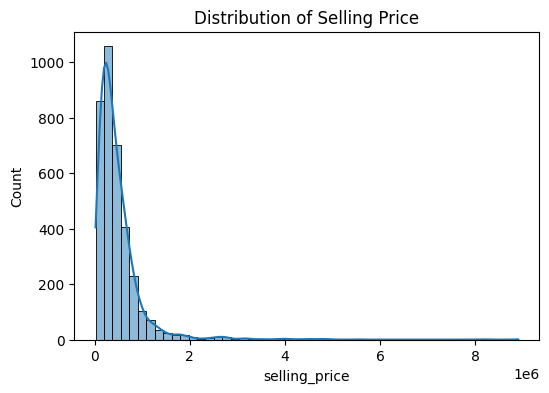

In [9]:
#Selling Price distribution
plt.figure(figsize=(6,4))
sns.histplot(df['selling_price'], bins=50, kde=True)
plt.title("Distribution of Selling Price")
plt.show()

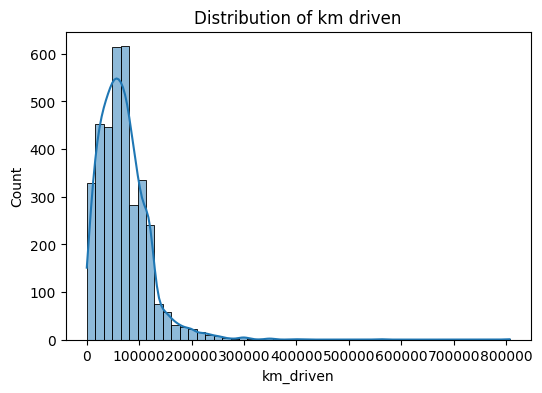

In [10]:
#Selling Price distribution
plt.figure(figsize=(6,4))
sns.histplot(df['km_driven'], bins=50, kde=True)
plt.title("Distribution of km driven")
plt.show()

In [11]:
# --- Feature engineering ------
# Extract brand from name
df['brand'] = df['name'].astype(str).str.split().str[0].fillna('unknown')
df['model_name'] = df['name'].apply(lambda x: " ".join(x.split()[1:]))

In [12]:
# Log transform target to reduce skewness
df = df[df['selling_price'] > 0]  # avoid log(0)
df['selling_price'] = np.log1p(df['selling_price'])

In [13]:
# Remove outliers in km_driven
q_low, q_hi = df['km_driven'].quantile([0.01, 0.99])
df = df[(df['km_driven'] >= q_low) & (df['km_driven'] <= q_hi)]

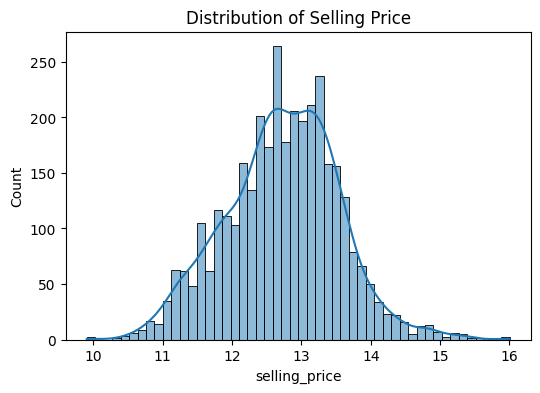

In [14]:
# Exploratory Data Analysis
# ===============================
#Selling Price distribution
plt.figure(figsize=(6,4))
sns.histplot(df['selling_price'], bins=50, kde=True)
plt.title("Distribution of Selling Price")
plt.show()

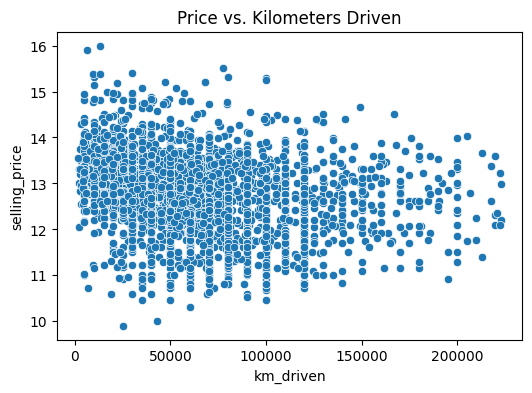

In [15]:
plt.figure(figsize=(6,4))
sns.scatterplot(x='km_driven', y='selling_price', data=df)
plt.title("Price vs. Kilometers Driven")
plt.show()

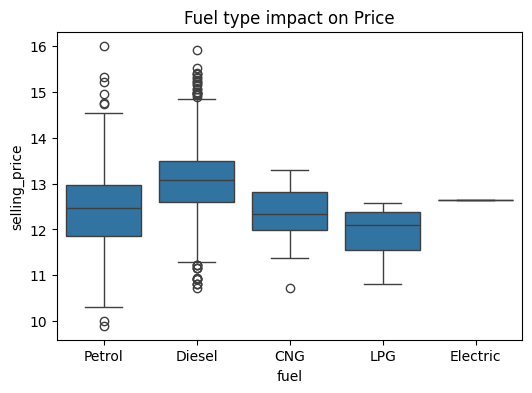

In [16]:
plt.figure(figsize=(6,4))
sns.boxplot(x='fuel', y='selling_price', data=df)
plt.title("Fuel type impact on Price")
plt.show()

In [17]:
# -- Define Features and Target --
# ===============================
X = df.drop(columns=['selling_price','name'])  # drop target + name (not useful)
y = df['selling_price']

In [18]:
# Categorical and numerical columns
categorical_cols = X.select_dtypes(include=['object']).columns
numerical_cols = X.select_dtypes(exclude=['object']).columns

In [19]:
print("Categorical columns:", categorical_cols)
print("Numerical columns:", numerical_cols)

Categorical columns: Index(['fuel', 'seller_type', 'transmission', 'owner', 'brand', 'model_name'], dtype='object')
Numerical columns: Index(['km_driven', 'car_age'], dtype='object')


In [20]:
# Preprocessor

preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numerical_cols ),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols)
    ]
)


In [21]:
#  Train-Test Split
# ===============================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [22]:
#  Models to Compare
# ===============================
models = {
    "LinearRegression": LinearRegression(),
    "Ridge": Ridge(alpha=1.0),
    "Lasso": Lasso(alpha=0.001),
    "RandomForest": RandomForestRegressor(n_estimators=300, max_depth=10, random_state=42),
    "GradientBoosting": GradientBoostingRegressor(n_estimators=200, learning_rate=0.1, random_state=42),
    "XGBoost": XGBRegressor(n_estimators=300, learning_rate=0.1, max_depth=10, subsample=0.8, colsample_bytree=0.8, random_state=42),
    "CatBoost": CatBoostRegressor(iterations=300, learning_rate=0.01, depth=10, verbose=0, random_state=42)
}

results = {}

In [23]:
# Model Training & Evaluation
# ===============================
for name, model in models.items():
    pipe = Pipeline(steps=[('preprocessor', preprocessor),
                           ('model', model)])
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)

    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    results[name] = {"R2": r2, "MAE": mae, "RMSE": rmse}

In [24]:
# Convert to DataFrame for comparison
results_df = pd.DataFrame(results).T
print("\nModel Comparison:\n")
print(results_df)


Model Comparison:

                        R2       MAE      RMSE
LinearRegression  0.847498  0.223870  0.307607
Ridge             0.852766  0.222884  0.302247
Lasso             0.777498  0.288017  0.371556
RandomForest      0.783066  0.281085  0.366878
GradientBoosting  0.797355  0.270283  0.354589
XGBoost           0.836264  0.234533  0.318735
CatBoost          0.748071  0.309111  0.395364


In [25]:
#  Best Model Insights
# ===============================
best_model_name = results_df['R2'].idxmax()
print(f"\n✅ Best Model: {best_model_name}")


✅ Best Model: Ridge


In [26]:
# Train best model fully
best_model = Pipeline(steps=[('preprocessor', preprocessor),
                             ('model', models[best_model_name])])
best_model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  Index(['km_driven', 'car_age'], dtype='object')),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  Index(['fuel', 'seller_type', 'transmission', 'owner', 'brand', 'model_name'], dtype='object'))])),
                ('model', Ridge())])

In [27]:
# Feature importance (for tree-based models)
if best_model_name in ["RandomForest", "GradientBoosting", "XGBoost", "CatBoost"]:
    # Get feature names after preprocessing
    feature_names = best_model.named_steps['preprocessor'].get_feature_names_out()

    importances = best_model.named_steps['model'].feature_importances_
    feat_imp = pd.Series(importances, index=feature_names).sort_values(ascending=False).head(10)

    plt.figure(figsize=(8,5))
    sns.barplot(x=feat_imp.values, y=feat_imp.index)
    plt.title(f"Top Features - {best_model_name}")
    plt.show()
else:
    print(f"Feature importance is not directly available for {best_model_name}.")

Feature importance is not directly available for Ridge.


In [28]:
# Hyperparameter Tuning
# ===============================

if best_model_name in [
    "RandomForest", "GradientBoosting", "DecisionTree",
    "AdaBoost", "LinearRegression", "Ridge",
    "Lasso", "XGBoost", "CatBoost"
]:
    print(f"\n🔍 Hyperparameter Tuning for {best_model_name}...")

    # Define parameter grids for supported models
    param_grids = {
        "RandomForest": {
            'model__n_estimators': [100, 200],
            'model__max_depth': [10, 15, 20],
            'model__min_samples_split': [2, 3, 5],
            'model__min_samples_leaf': [1, 2, 4]
        },
        "GradientBoosting": {
            'model__n_estimators': [100, 200, 300],
            'model__learning_rate': [0.05, 0.1, 0.2],
            'model__max_depth': [3, 5, 7],
            'model__subsample': [0.8, 1.0]
        },
        "DecisionTree": {
            'model__max_depth': [None, 10, 20, 30],
            'model__min_samples_split': [2, 5, 10],
            'model__min_samples_leaf': [1, 2, 4]
        },
        "AdaBoost": {
            'model__n_estimators': [50, 100, 200],
            'model__learning_rate': [0.01, 0.05, 0.1, 1.0]
        },
        "LinearRegression": {
            'model__fit_intercept': [True, False],
        },
        "Ridge": {
            'model__alpha': [0.1, 1.0, 10.0],
        },
        "Lasso": {
            'model__alpha': [0.1, 1.0, 10.0],
        },
        "XGBoost": {
            "model__n_estimators": [200, 400, 600],
            "model__max_depth": [4, 6, 8],
            "model__learning_rate": [0.01, 0.05, 0.1],
            "model__subsample": [0.7, 0.8, 1.0],
            "model__colsample_bytree": [0.7, 0.8, 1.0],
            "model__gamma": [0, 0.1, 0.2]
        },
        "CatBoost": {
            "model__depth": [6, 8, 10],
            "model__learning_rate": [0.01, 0.05, 0.1],
            "model__iterations": [300, 500, 800],
            "model__l2_leaf_reg": [1, 3, 5, 7],
            "model__bagging_temperature": [0, 0.5, 1]
        }
    }

    # Get the parameter grid for the best model
    param_grid = param_grids.get(best_model_name, None)

    # Create pipeline
    grid_pipe = Pipeline(steps=[('preprocessor', preprocessor),
                                ('model', models[best_model_name])])

    # GridSearchCV
    grid_search = GridSearchCV(
            estimator=grid_pipe,
            param_grid=param_grid,
            cv=5,
            scoring='r2',
            n_jobs=-1,
            verbose=2
        )
    grid_search.fit(X_train, y_train)

    print("\n✅ Best Parameters:", grid_search.best_params_)
    print("✅ Best CV R² Score:", grid_search.best_score_)
else:
    print(f"\nHyperparameter tuning is not implemented for {best_model_name}.")


🔍 Hyperparameter Tuning for Ridge...
Fitting 5 folds for each of 3 candidates, totalling 15 fits

✅ Best Parameters: {'model__alpha': 0.1}
✅ Best CV R² Score: 0.8450597797853467


In [29]:
# Create pipeline
grid_pipe = Pipeline(steps=[('preprocessor', preprocessor),
                                ('model', models[best_model_name])])

In [30]:
 # Evaluate on test set
tuned_model = grid_search.best_estimator_
y_pred_tuned = tuned_model.predict(X_test)

tuned_r2 = r2_score(y_test, y_pred_tuned)
tuned_mae = mean_absolute_error(y_test, y_pred_tuned)
tuned_rmse = np.sqrt(mean_squared_error(y_test, y_pred_tuned))

print("\n📊 Tuned Model Performance on Test Set:")
print("R²:", tuned_r2)
print("MAE:", tuned_mae)
print("RMSE:", tuned_rmse)


📊 Tuned Model Performance on Test Set:
R²: 0.8533642829883145
MAE: 0.22037024815479597
RMSE: 0.3016322071144295


In [31]:
# Feature importance again
if best_model_name in ["RandomForest", "GradientBoosting", "XGBoost", "CatBoost"]:
    # Get feature names from preprocessed training data
    preprocessed_X_train = tuned_model.named_steps['preprocessor'].transform(X_train)
    # If the output is a sparse matrix, convert to dense and get column names
    if isinstance(preprocessed_X_train, np.ndarray):
        feature_names = tuned_model.named_steps['preprocessor'].get_feature_names_out()
    else: # Assuming sparse matrix
        feature_names = tuned_model.named_steps['preprocessor'].get_feature_names_out()


    importances = tuned_model.named_steps['model'].feature_importances_
    feat_imp = pd.Series(importances, index=feature_names).sort_values(ascending=False).head(10)

    plt.figure(figsize=(8,5))
    sns.barplot(x=feat_imp.values, y=feat_imp.index)
    plt.title(f"Top Features - Tuned {best_model_name}")
    plt.show()
else:
    print(f"Feature importance is not directly available for Tuned {best_model_name}.")

Feature importance is not directly available for Tuned Ridge.


In [32]:
# Save the Final Model
# ===============================
import pickle

# Save tuned model if available, else best_model
final_model = tuned_model if 'tuned_model' in locals() else best_model

with open("used_car_price_model.pkl", "wb") as f:
    pickle.dump(final_model, f)

print("✅ Model saved as used_car_price_model.pkl")


✅ Model saved as used_car_price_model.pkl


In [33]:
#  Load the Model (Example)
# ===============================
import pickle

# Save tuned model if available, else best_model
final_model = tuned_model if 'tuned_model' in locals() else best_model

with open("used_car_price_model.pkl", "wb") as f:
    pickle.dump(final_model, f)

print("✅ Model saved as used_car_price_model.pkl")

# Load the Model (Example)
# ===============================
with open("used_car_price_model.pkl", "rb") as f:
    loaded_model = pickle.load(f)

# Test with sample data
sample = X_test.iloc[0:1]   # take first row from test set

pred_price = loaded_model.predict(sample)
raw_price = np.expm1(pred_price[0])
print("\n🚗 Predicted Price for used Car:", round(raw_price,3))

✅ Model saved as used_car_price_model.pkl

🚗 Predicted Price for used Car: 553615.945
